In [82]:
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
import json
import os
import pandas as pd
import copy
from scipy.ndimage.interpolation import shift
from tqdm import tqdm

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

In [83]:
base_path = "/nfs/home/nduginets/"
dataset_path = os.path.join(base_path, "master-diploma/bboxes/bounding_boxes_metadata.csv")

frame = pd.read_csv(dataset_path)

imgs_path = "/mnt/tank/scratch/nduginets/images/pix2pix_datasets/base_dataset_folder/images_512p"

frame = pd.read_csv(dataset_path)
images_list = sorted(glob.glob(os.path.join(imgs_path, "*.png")))

images_names = list(map(lambda x: x.split("/")[-1].split(".")[0], images_list))

In [84]:

IMAGE_PATH = "/mnt/tank/scratch/nduginets/images/noise_bboxes_v2/images"
SEGMENTATION_PATH = "/mnt/tank/scratch/nduginets/images/noise_bboxes_v2/segmentation"
ATTRIBUTES_PATH = "/mnt/tank/scratch/nduginets/images/noise_bboxes_v2/attributes"


os.makedirs(IMAGE_PATH, exist_ok=True)
os.makedirs(SEGMENTATION_PATH, exist_ok=True)
os.makedirs(ATTRIBUTES_PATH, exist_ok=True)

type_path_offset_list = [
    ("image", IMAGE_PATH),
    ("segmentation", SEGMENTATION_PATH),
    ("attribute_globules", ATTRIBUTES_PATH),
    ("attribute_milia_like_cyst", ATTRIBUTES_PATH),
    ("attribute_negative_network", ATTRIBUTES_PATH),
    ("attribute_pigment_network", ATTRIBUTES_PATH),
    ("attribute_streaks", ATTRIBUTES_PATH),
]

multipliers = [1, 1.1, 1.2, 1.56]
adds = [-0.2, -0.15, -0.1, 0, 0.1, 0.15, 0.2]

In [85]:
#  4 * 15
sz = 4 * 15
columns = frame.columns[1:]

attributes = [
    columns[i * sz: (i + 1) * sz]
    for i in range(6)
]

In [86]:
def fill_cnt_tensor(t):
        zeros = np.zeros((6, 16))
        for des in range(0, 6):
            cnt = 0
            for i in range(0, 15):
                offset = des * sz + i * 4
                if t[offset] != 0:
                    cnt += 1
            zeros[des][cnt] = 1
        return tuple(np.argmax(zeros, axis=1))
fill_cnt_tensor(frame.iloc[2][1:])

map_tuple_to_indexes = {}

for idx in range(len(frame.index)):
    image_coordinates = frame.iloc[idx][1:]
    tpl = fill_cnt_tensor(image_coordinates)
    if tpl not in map_tuple_to_indexes:
        map_tuple_to_indexes[tpl] = (0, [])
    new_cnt = map_tuple_to_indexes[tpl][0] + 1
    new_lsr = map_tuple_to_indexes[tpl][1]
    new_lsr.append(idx)
    map_tuple_to_indexes[tpl] = (new_cnt, new_lsr)

list_tuple_to_indexes = sorted([(k, v[0], v[1]) for k, v in map_tuple_to_indexes.items()], key=lambda x: x[1], reverse=True)


In [92]:
lbls = ["segm", "globules", "milia_like_cyst", "negative_network", "pigment_network", "streaks"]

def populate(lbl_list, max_cnt=100):
    result = []
    selected_tuples = set()
    for l in lbl_list:
        cnt = 0
        for r, _, items in filter(lambda x: x[0][lbls.index(l)] > 0, list_tuple_to_indexes):
            if cnt == max_cnt:
                continue
            if r in selected_tuples:
                continue
            cnt += 1
            selected_tuples.add(r)
            result.append((r, items[0]))
    return result

tuple_index_to_noise = populate(["streaks", "negative_network", "globules", "milia_like_cyst", "negative_network"], 25)



In [93]:
def fill_zeros(index, number_to_fill = '9'):
    number = str(index)
    return "ISIC_" + number_to_fill * (7 - len(number)) + number

print(fill_zeros(1_00_00_00))

ISIC_1000000


In [94]:
print(tuple_index_to_noise[0][1])

frame.iloc[152]

152


name                 ISIC_0000167
segm_x_0                 0.011719
segm_y_0                 0.241162
segm_x_size_0            0.787109
segm_y_size_0             0.47601
                         ...     
streaks_y_size_13               0
streaks_x_14                    0
streaks_y_14                    0
streaks_x_size_14               0
streaks_y_size_14               0
Name: 152, Length: 361, dtype: object

In [95]:
def noise_row(row, x_offset, y_offset, x_wide, y_wide):
    for j, attribute in enumerate(attributes):
        for i, a in enumerate(attribute):
            if "x_size" in a:
                row[j * sz + i] *= x_wide
            elif "y_size" in a:
                row[j * sz + i] *= y_wide
            elif "x" in a:
                row[j * sz + i] += x_offset
            elif "y" in a:
                row[j * sz + i] += y_offset
            else:
                raise Error("!!!!")
    return row



def draw_image(row, offset, shape):
    image = np.zeros((shape[0], shape[1]), dtype=np.int32)
    calibrate_x = lambda s: max(0, min(s, shape[0]))
    calibrate_y = lambda s: max(0, min(s, shape[1]))
    
    parts = row[offset * sz: (offset + 1) * sz]
    for idx in range(0, len(parts), 4):
        x = calibrate_x(int(parts[idx] * shape[0]))
        y = calibrate_y(int(parts[idx + 1] * shape[1]))
        x_sz = calibrate_x(int(parts[idx + 2] * shape[0]))
        y_sz = calibrate_y(int(parts[idx + 3] * shape[1]))

        image[x: x + x_sz, y: y + y_sz] = 1
    return image
    

In [100]:

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean


def fill_with_mean_image_part(image_to_populate, base_image, row, offset):
    shape = base_image.shape
    mask = draw_image(row, offset, shape)
    mean = np.mean(base_image, axis=(0, 1))
    image_to_populate[mask == 1] = mean
    return image_to_populate


def move_image_part(image_to_populate, base_image, row, offset, shift_value, rescale_value):
    shape = base_image.shape
    mask = draw_image(row, offset, shape)
    
    calibrate_x = lambda s: int(max(0, min(s, shape[0])))
    calibrate_y = lambda s: int(max(0, min(s, shape[1])))
    
    for pos in range(sz // 4):
        x_o = calibrate_x(row[offset * sz + pos * 4] * shape[0])
        y_o = calibrate_y(row[offset * sz + pos * 4 + 1] * shape[1])
        x_s = calibrate_x(row[offset * sz + pos * 4 + 2] * shape[0])
        y_s = calibrate_y(row[offset * sz + pos * 4 + 3] * shape[1])
        subpart = base_image[x_o:x_o + x_s, y_o:y_o + y_s]
        if subpart.shape[0] == 0 or subpart.shape[1] == 0: 
            continue
        #print(subpart.shape)
        subpart_rescaled = rescale(subpart, (rescale_value, rescale_value, 1))
        
        x_s_n = calibrate_x(x_o + shape[0] * shift_value)
        y_s_n = calibrate_y(y_o + shape[1] * shift_value)
        x_e_n = calibrate_x(x_s_n + calibrate_x(x_s * rescale_value))
        y_e_n = calibrate_y(y_s_n + calibrate_y(y_s * rescale_value))
        
        x_len = x_e_n - x_s_n
        y_len = y_e_n - y_s_n
        
        image_to_populate[x_s_n: x_e_n, y_s_n:y_e_n] = subpart_rescaled[:x_len, :y_len]
       
    
    return image_to_populate
    
def make_new_image(img, row, shift_value, rescale_value):
    image_to_populate = np.copy(img)
    for i in range(0, 6):
        image_to_populate = fill_with_mean_image_part(image_to_populate, img, row, i)
        
    for i in range(0, 6):
        image_to_populate = move_image_part(image_to_populate, img, row, i, shift_value, rescale_value)
    return image_to_populate


def make_row_from_images(row, index, shift_value, rescale_value):
    name = os.path.join(imgs_path, row['name'] + ".png")
    row = np.array(row[1:])
    images = []
    img = resize(np.array(Image.open(name)), (512, 512, 3))
    shifted_image = make_new_image(img, row, shift_value, rescale_value)
    images.append(shifted_image)
    noised_row = noise_row(row, shift_value, shift_value, rescale_value, rescale_value)
    for i in range(6):
        mask = draw_image(noised_row, i, img.shape)
        images.append(mask)
    assert len(images) == 7
    
    result_files = []
    for i in range(0, len(images)):
        type_name, path = type_path_offset_list[i]
        full_path = os.path.join(path, fill_zeros(index) + "_" + type_name + ".png")
        Image.fromarray((images[i] * 255).astype(np.uint8)).save(full_path)
        result_files.append(full_path)
    return result_files


res = make_row_from_images(frame.iloc[68], 1, 0, 1)

print(np.unique(np.array(Image.open(res[0]))))
print(np.unique(np.array(Image.open(res[1]))))
print(np.unique(np.array(Image.open(res[2]))))
print(np.unique(np.array(Image.open(res[3]))))
print(np.unique(np.array(Image.open(res[4]))))
print(np.unique(np.array(Image.open(res[5]))))



[ 27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 255]
[  0 255]
[  0 255]
[0]
[0]
[  0 255]


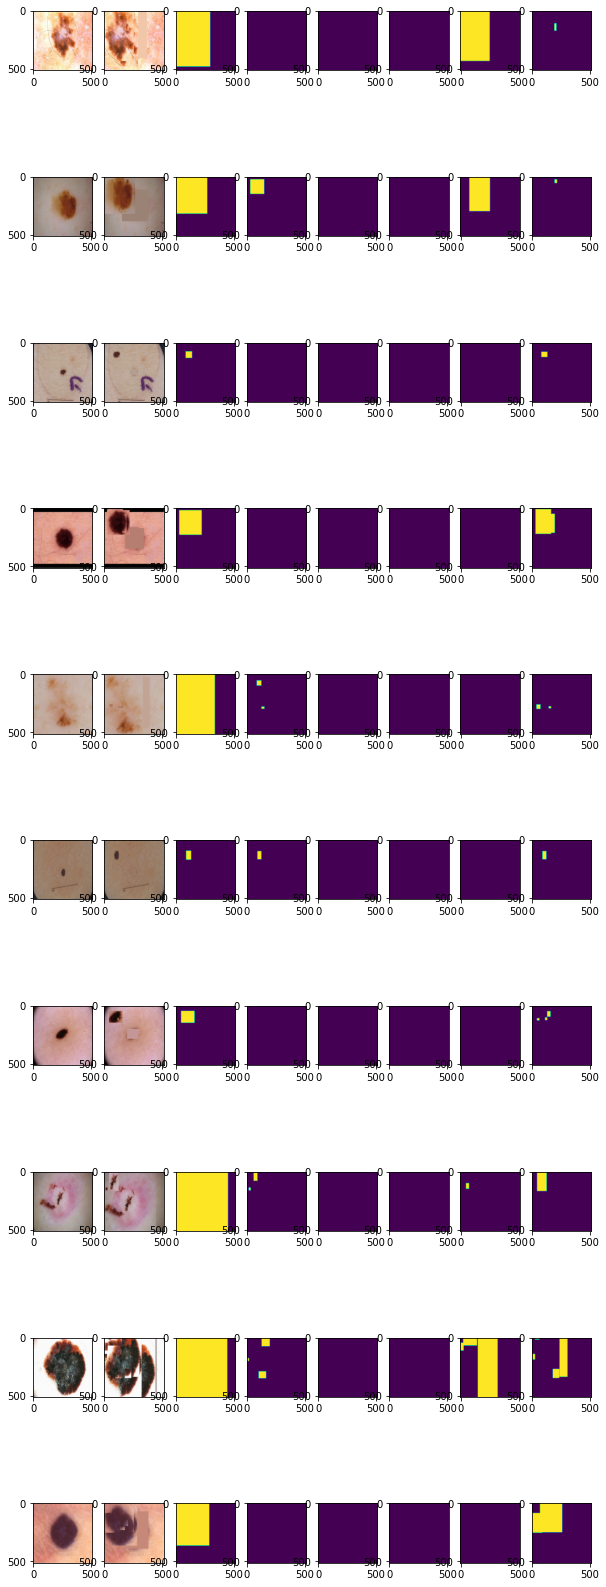

In [103]:
cnt = 10
fig, plots = plt.subplots(nrows=cnt, ncols=8, figsize = (10,30))

for idx, (_, n) in enumerate(tuple_index_to_noise[0:cnt]):
    row = np.array(frame.iloc[n][1:])
    name = os.path.join(imgs_path, frame.iloc[n]['name'] + ".png")
    images = []
    img = resize(np.array(Image.open(name)), (512, 512, 3)) 
    
    images.append(img)
    
    x, y = (-0.3, 1.2)
    images.append(make_new_image(img, row, x, y))
    nosied_row = noise_row(row, x, x, y, y)
    for i in range(6):
        mask = draw_image(nosied_row, i, img.shape)
        images.append(mask)
    
    for jdx, img in enumerate(images):
        plots[idx][jdx].imshow(img)
plt.show()

In [104]:
print(tuple_index_to_noise[0])

list_of_a_b_idx = []
for (_, p) in tuple_index_to_noise:
    for a in adds:
        for b in multipliers:
            list_of_a_b_idx.append((a, b, p))
len(list_of_a_b_idx)

((1, 0, 0, 0, 1, 1), 152)


3500

In [105]:
from joblib import Parallel, delayed

def print_some(idx, v):
    row = frame.iloc[v[2]]
    a = v[0]
    b = v[1]
    make_row_from_images(row, idx, a, b)

res = Parallel(n_jobs=30)(delayed(print_some)(idx, v) for idx,v in tqdm(list(enumerate(list_of_a_b_idx))))


100%|██████████| 3500/3500 [01:11<00:00, 49.20it/s]
